In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.figsize"] = (20,10) # aby wykresy w Colabie były większe

import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from termcolor import cprint

import plotly.graph_objects as go

import plotly.express as px

import time

from auxiliary_funcs import *

rs = 42

np.random.seed(rs)
torch.manual_seed(rs);

Zainstalowana wersja scikit-learn: 1.0.2.


# Dataset Exploration

In [19]:
data_dir = Path("./Gable-roof/")

In [20]:
for f in data_dir.iterdir():
    print(f)

Gable-roof/Archiwalne
Gable-roof/.DS_Store
Gable-roof/ML and usable area.png
Gable-roof/Dwuspady_projektowe.xlsx
Gable-roof/Koszalin_znana_norma.xlsx
Gable-roof/Dwuspady_projektowe_archived.xlsx
Gable-roof/Koszalin_znana_norma-kopia.xlsx
Gable-roof/Koszalin_nieznana_norma.xlsx


In [21]:
curr_file = data_dir.joinpath("Dwuspady_projektowe.xlsx")

In [22]:
curr_file_dict = pd.read_excel(curr_file, sheet_name=None)
curr_file_dict.keys()

dict_keys(['Without garages or boiler rooms', 'Without garages, with boilers', 'With garages and boiler rooms'])

## Dataset 1 
Input data: Varying  
Output: Usable area [m2]

In [23]:
dataset_name = "Without garages or boiler rooms"


curr_df = curr_file_dict[dataset_name]

curr_df["Height of a knee wall [m]"] = curr_df["Height of a knee wall [m]"].replace('mieszane', curr_df["Height of a knee wall [m]"].replace('mieszane', np.NaN).mean())
curr_df = curr_df.replace("unknown", np.NaN)

for col in curr_df.columns:
    if col not in ["Remarks", "Artificial example?", "Unnamed: 19"]:
        if curr_df[col].isna().sum() > 0:
            curr_df[col] = curr_df[col].replace(np.NaN, curr_df[col].mean())

curr_df = curr_df.drop(["Unnamed: 19"], axis=1)

wo_garages_boilers_df = curr_df.copy()

## Dataset 2
Input data: Varying  
Output: Usable area [m2]

In [24]:
dataset_name = "Without garages, with boilers"


curr_df = curr_file_dict[dataset_name]

curr_df["Height of a knee wall [m]"] = curr_df["Height of a knee wall [m]"].replace('mieszane', curr_df["Height of a knee wall [m]"].replace('mieszane', np.NaN).mean())
curr_df = curr_df.replace("unknown", np.NaN)

for col in curr_df.columns:
    if col not in ["Remarks", "Artificial example?", "Unnamed: 19"]:
        if curr_df[col].isna().sum() > 0:
            curr_df[col] = curr_df[col].replace(np.NaN, curr_df[col].mean())

wo_garages_w_boilers_df = curr_df.copy()

## Dataset 1+2
Input data: Varying  
Output: Usable area [m2]

In [25]:
ds_1_2 = pd.concat([wo_garages_boilers_df, wo_garages_w_boilers_df])

# Model Testing

In [26]:
model_dir = Path("./modele/Final_models/Dataset1")
model_dir_2 = Path("./modele/Final_models/Dataset1and2")
model_list = list(model_dir.iterdir())
model_list_2 = list(model_dir_2.iterdir())

In [27]:
for f in model_dir.iterdir():
    print(f)
for f in model_dir_2.iterdir():
    print(f)

modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Number of stories]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =1,5_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m]]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m], Number of stories]_|_dataset=Without garages or boiler rooms.pt
modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages, with boilers.pt
modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m], Perimeter [cm]]_|_dataset=Without garages, with boilers.pt


## Model 1

**NN**

In [28]:
model_path = model_list[0]
learning_rate=0.1
λ=0.5
used_cols = ["Covered area [m2]", "Number of stories"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 10)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))
scaler = StandardScaler()

used_ds = wo_garages_boilers_df
df_train_and_val, df_test = train_test_split(used_ds, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

df_test = df_test.reset_index()
X_test = df_test[used_cols].to_numpy()
Y_test = df_test["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = df_test.join(df_pred)

df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_nn = df_test_viz.copy()

**Linear Regression**

In [29]:
df_reg = regression(wo_garages_boilers_df, used_cols, dataset_name, rs=rs, out=True, show_plot=False)

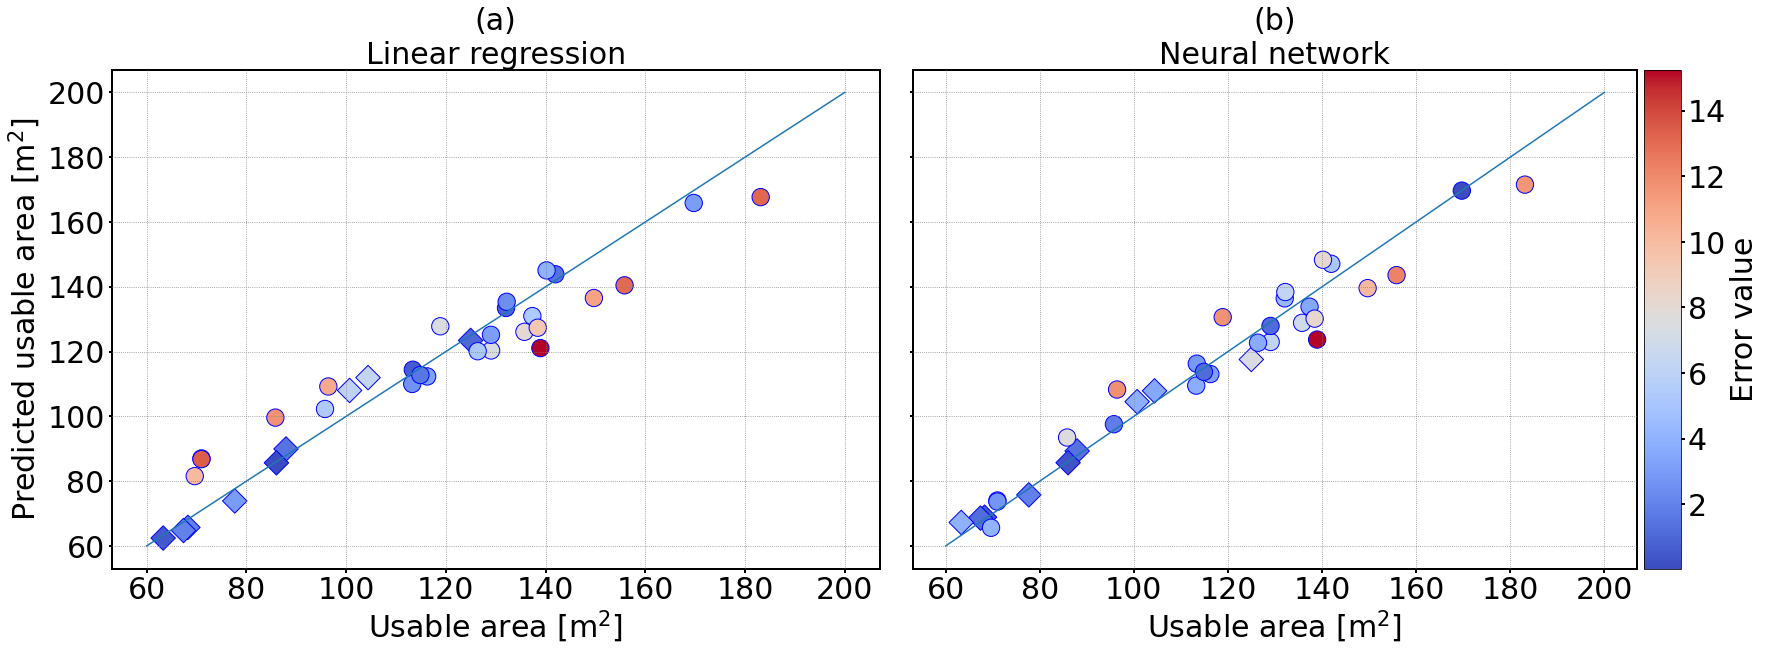

In [31]:
models_comparison_figure(df_reg, df_nn, plot_name="Reg_VS_NN_1.pdf")

## Model 2

In [32]:
model_list[1]

PosixPath('modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =1,5_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages or boiler rooms.pt')

### Model loading

In [33]:
model_path = model_list[1]
learning_rate=0.1
λ=1.5
used_cols = ["Covered area [m2]", "Height [m]", "Number of stories", "Height of a knee wall [m]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 30)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))
scaler = StandardScaler()


used_ds = wo_garages_boilers_df
df_train_and_val, df_test = train_test_split(used_ds, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

df_test = df_test.reset_index()
X_test = df_test[used_cols].to_numpy()
Y_test = df_test["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = df_test.join(df_pred)

df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_nn = df_test_viz.copy()

**Linear Regression**

In [34]:
df_reg = regression(wo_garages_boilers_df, used_cols, dataset_name, rs=rs, out=True, show_plot=False)

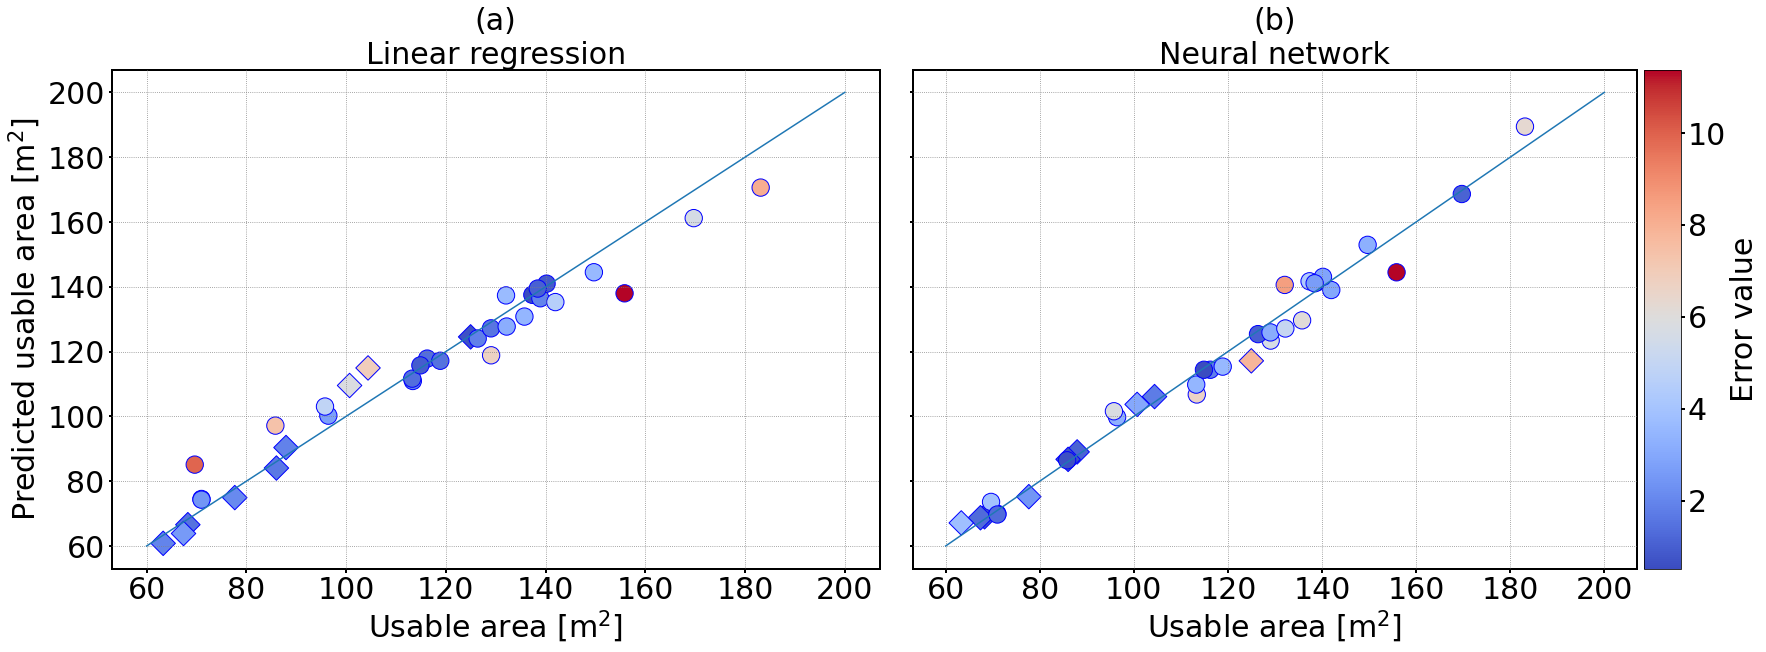

In [35]:
models_comparison_figure(df_reg, df_nn, plot_name="Reg_VS_NN_2.pdf")

## Model 3

In [36]:
model_list[2]

PosixPath('modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m]]_|_dataset=Without garages or boiler rooms.pt')

### Model loading

In [37]:
model_path = model_list[2]
learning_rate=0.1
λ=0.5
used_cols = ["Covered area [m2]", "Height [m]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 10)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))
scaler = StandardScaler()


used_ds = wo_garages_boilers_df
df_train_and_val, df_test = train_test_split(used_ds, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

df_test = df_test.reset_index()
X_test = df_test[used_cols].to_numpy()
Y_test = df_test["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = df_test.join(df_pred)

df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_nn = df_test_viz.copy()

**Linear Regression**

In [38]:
df_reg = regression(wo_garages_boilers_df, used_cols, dataset_name, rs=rs, out=True, show_plot=False)

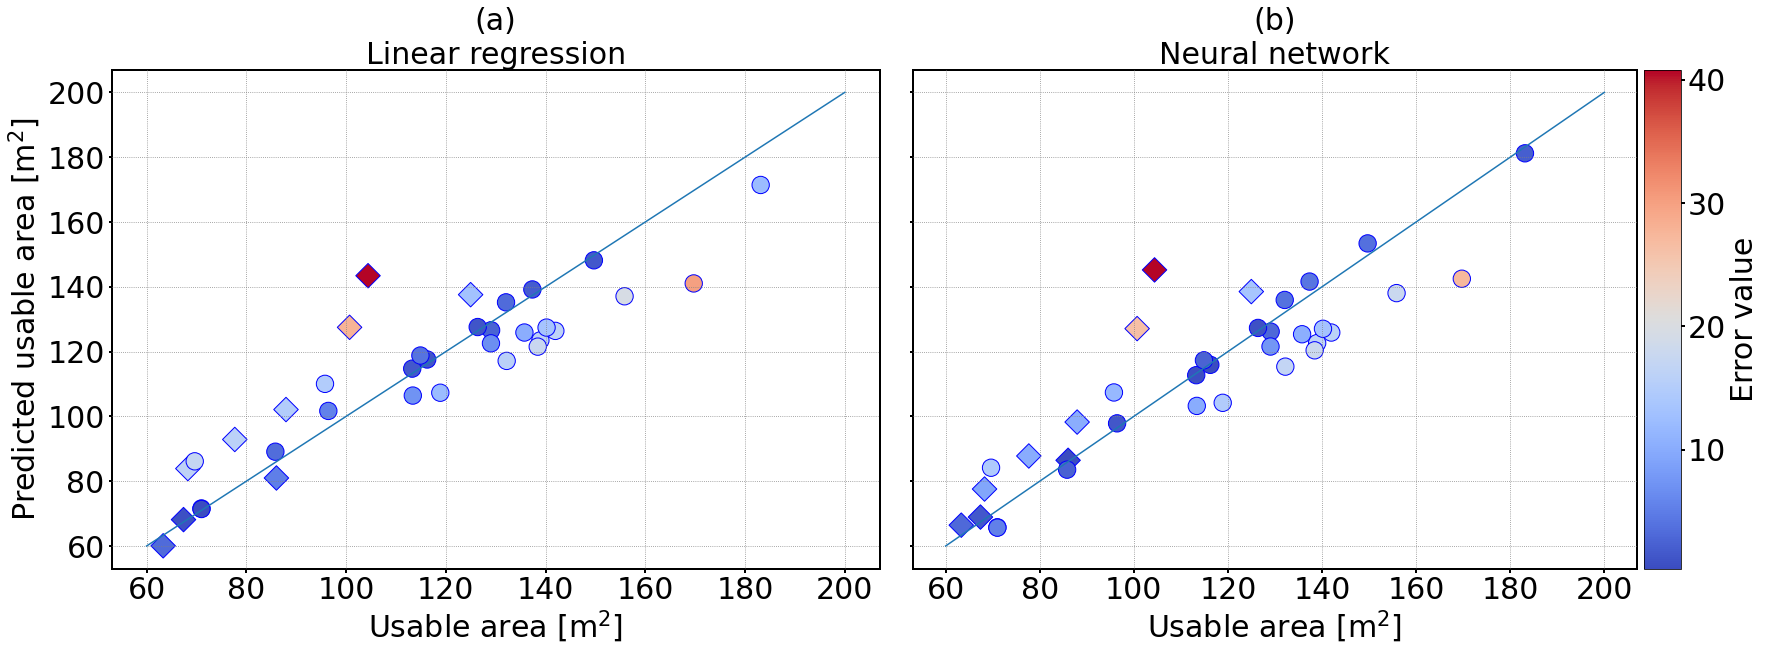

In [39]:
models_comparison_figure(df_reg, df_nn, plot_name="Reg_VS_NN_3.pdf")

## Model 4

In [40]:
model_list[3]

PosixPath('modele/Final_models/Dataset1/DNN_lr=0,1_|_λ =0,5_cols=[Covered area [m2], Height [m], Number of stories]_|_dataset=Without garages or boiler rooms.pt')

### Model loading

In [41]:
model_path = model_list[3]
learning_rate=0.1
λ=0.5
used_cols = ["Covered area [m2]", "Height [m]", "Number of stories"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 10)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))
scaler = StandardScaler()

used_ds = wo_garages_boilers_df
df_train_and_val, df_test = train_test_split(used_ds, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

df_test = df_test.reset_index()
X_test = df_test[used_cols].to_numpy()
Y_test = df_test["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = df_test.join(df_pred)

df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_nn = df_test_viz.copy()

**Linear Regression**

In [42]:
df_reg = regression(wo_garages_boilers_df, used_cols, dataset_name, rs=rs, out=True, show_plot=False)

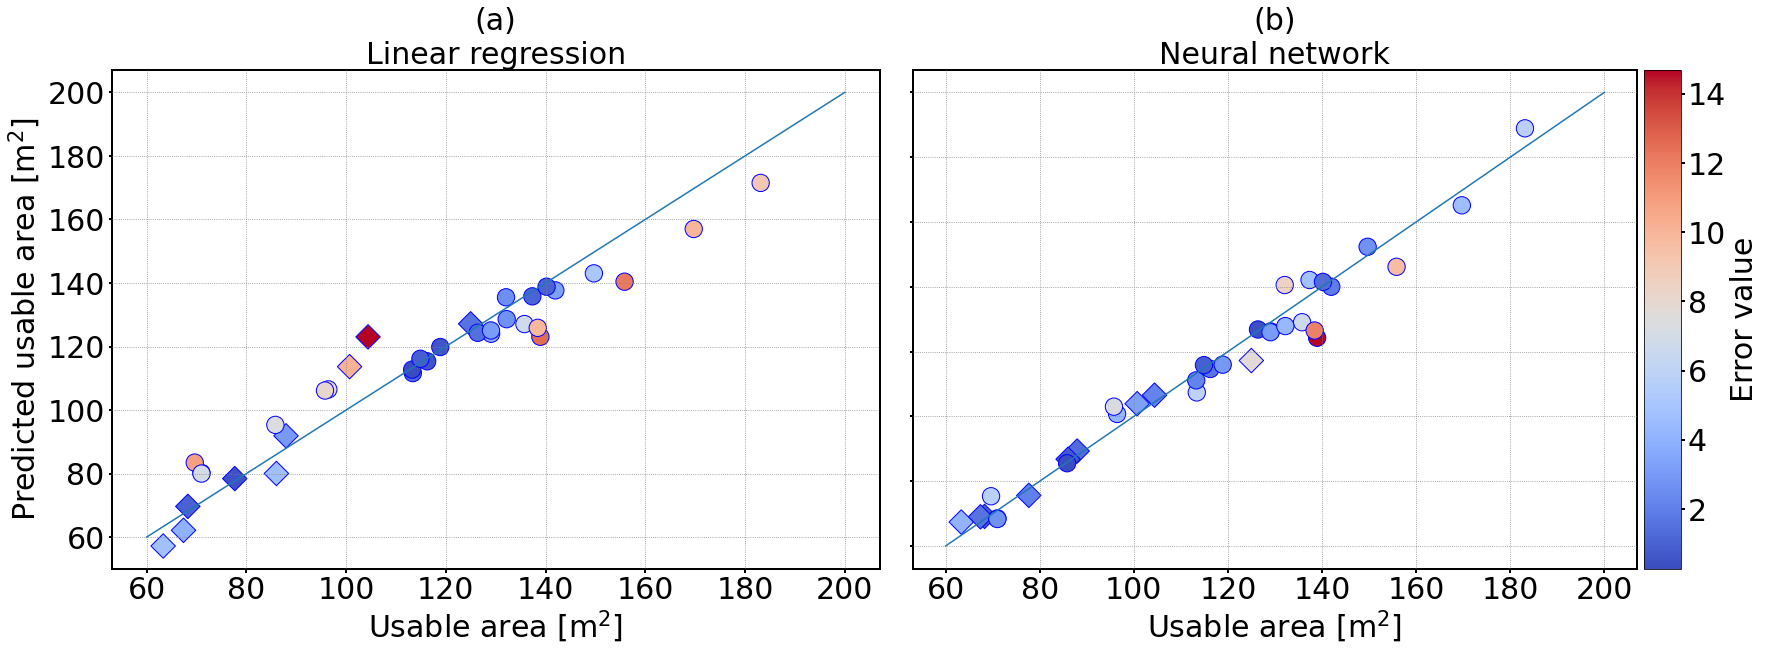

In [43]:
models_comparison_figure(df_reg, df_nn, plot_name="Reg_VS_NN_4.pdf")

## Model 5

In [44]:
model_list_2[0]

PosixPath('modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m]]_|_dataset=Without garages, with boilers.pt')

### Model loading

In [45]:
model_path = model_list_2[0]
learning_rate=0.1
λ=1.25
used_cols = ["Covered area [m2]", "Number of stories", "Height [m]", "Height of a knee wall [m]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 50)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))
scaler = StandardScaler()

used_ds = ds_1_2
df_train_and_val, df_test = train_test_split(used_ds, test_size=0.2, random_state=rs)

df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

df_test = df_test.reset_index()
X_test = df_test[used_cols].to_numpy()
Y_test = df_test["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = df_test.join(df_pred)

df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_nn = df_test_viz.copy()

**Linear Regression**

In [46]:
df_reg = regression(ds_1_2, used_cols, dataset_name, rs=rs, out=True, show_plot=False)

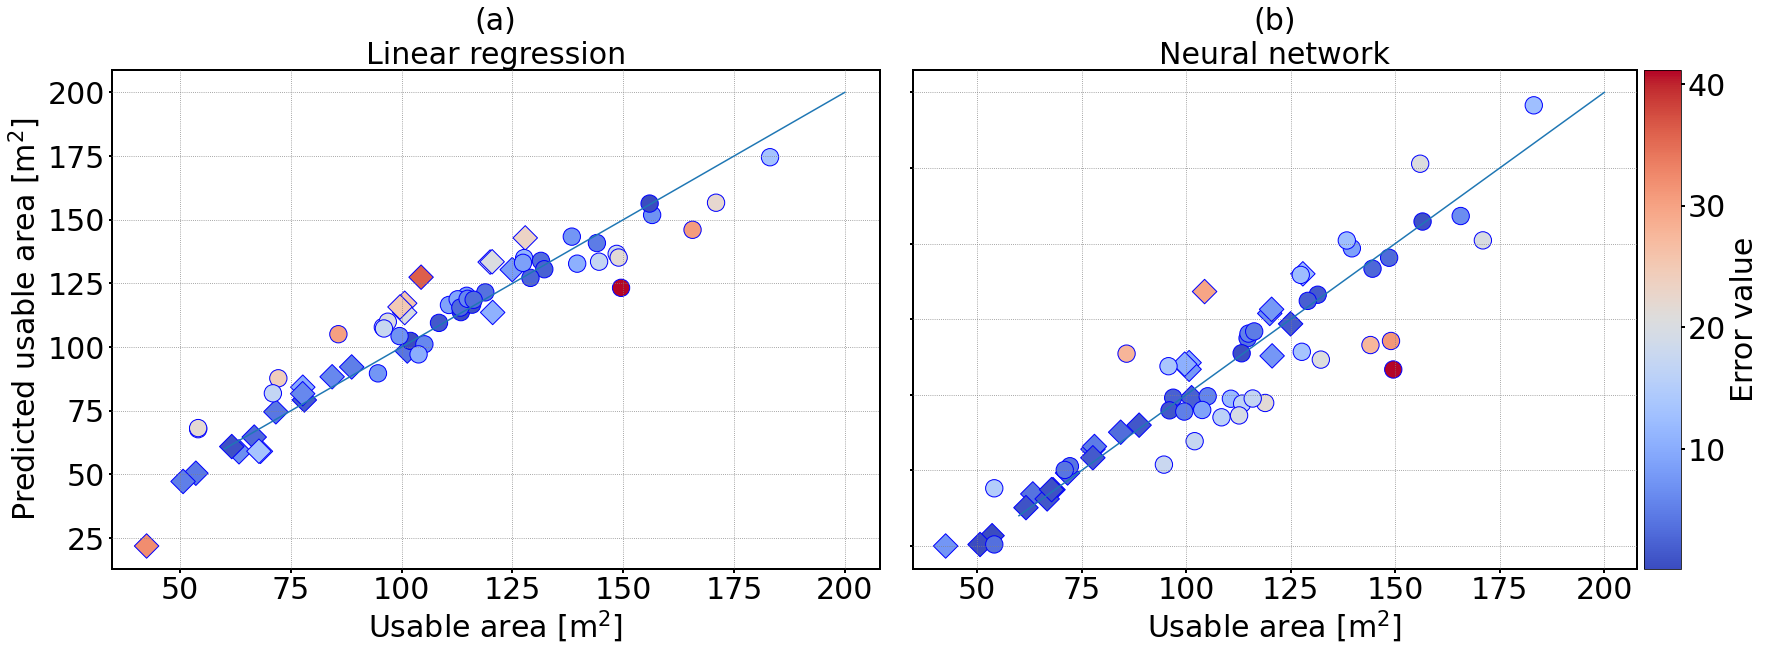

In [47]:
models_comparison_figure(df_reg, df_nn, plot_name="Reg_VS_NN_5.pdf")

## Model 6

In [48]:
model_list_2[1]

PosixPath('modele/Final_models/Dataset1and2/DNN_lr=0,1_|_λ =1,25_cols=[Covered area [m2], Height [m], Number of stories, Height of a knee wall [m], Perimeter [cm]]_|_dataset=Without garages, with boilers.pt')

### Model loading

In [49]:
model_path = model_list_2[1]
learning_rate=0.1
λ=1.5
used_cols = ["Covered area [m2]", "Height [m]", "Number of stories", "Height of a knee wall [m]", "Perimeter [cm]"]
input_size = len(used_cols)
architecture=DeepNet
milestones = [200, 400, 1700, 1900]
arch_params = (input_size, 1, 50)
model = architecture(*arch_params).double()
model.load_state_dict(torch.load(model_path))
scaler = StandardScaler()

used_ds = ds_1_2
df_train_and_val, df_test = train_test_split(used_ds, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_train_and_val, test_size=0.25, random_state=rs)
Y_train = df_train["Usable area [m2]"]
X_train = df_train[used_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(X_train)

df_test = df_test.reset_index()
X_test = df_test[used_cols].to_numpy()
Y_test = df_test["Usable area [m2]"]
X_test = scaler.transform(X_test)
test_features = Variable(torch.from_numpy(X_test))
test_labels = Variable(torch.from_numpy(Y_test.to_numpy()).double())
# Model evaluation
with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        Y_pred = model(test_features).numpy().reshape(-1)
        df_pred = pd.DataFrame(Y_pred, columns=["Predicted Usable Area [m2]"])
        df_test_viz = df_test.join(df_pred)

df_test_viz["Error"] = np.abs(df_test_viz["Usable area [m2]"] - df_test_viz["Predicted Usable Area [m2]"])

df_nn = df_test_viz.copy()

**Linear Regression**

In [50]:
df_reg = regression(ds_1_2, used_cols, dataset_name, rs=rs, out=True, show_plot=False)

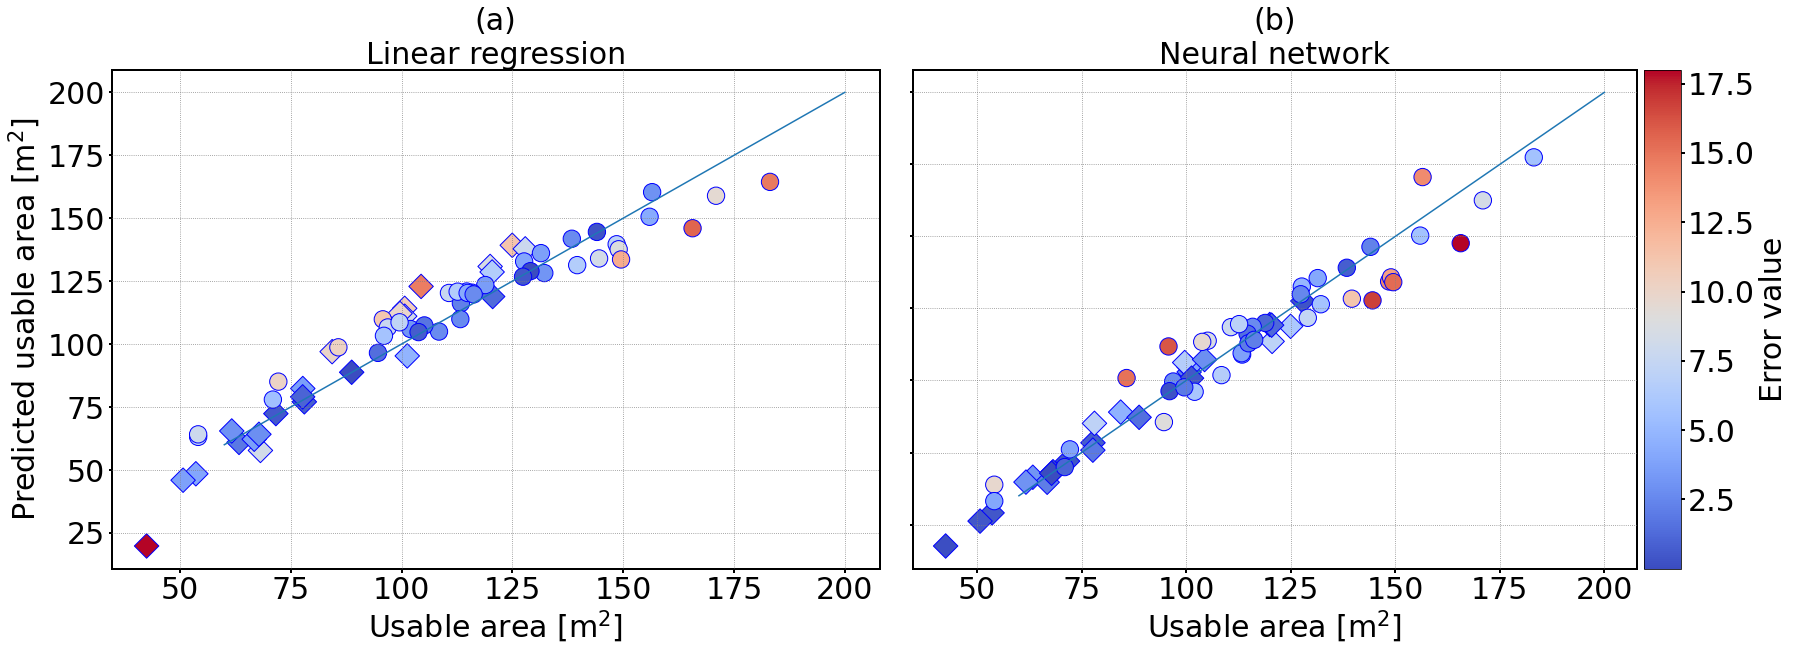

In [51]:
models_comparison_figure(df_reg, df_nn, plot_name="Reg_VS_NN_6.pdf")